## Compartment model, mean response D-optimal

In [93]:
using Plots
using LinearAlgebra

#objective function h to minimize
function infmat(x)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    p = length(theta)
    mat = zeros(p,p)
    for i in 1:n
        c1 = a[i]*theta[3]*exp(-theta[1]*a[i])
        c2 = -a[i]*theta[3]*exp(-theta[2]*a[i]) 
        c3 = exp(-theta[2]*a[i])-exp(-theta[1]*a[i])
        f = [c1, c2, c3]
        mat = mat + b[i] .* f*f'
    end
    return mat
end

# projection function onto the design space
function proj(x, design)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    
    a = max.(a,design[1])
    a = min.(a,design[2])
    
    u = sort(b, rev=true)
    j = n
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    b = b[1:(n-1)]
    
    return [a;b]
end

proj (generic function with 1 method)

In [94]:
function diter()
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, 2k-1)
    x = (design[2]-design[1])*rand(nptc*k) .+ design[1]
    x = reshape(x,nptc,k)
    w = rand(nptc*(k-1))
    w = reshape(w,nptc,k-1)
    ptc = hcat(x,w)
    for j in 1:nptc
        ptc[j,:] = proj(ptc[j,:],design)
    end
    pbest = ptc
    pbesth = zeros(nptc)
    for i in 1:nptc
        pbesth[i] = det(infmat(pbest[i,:]))
    end
    gbesth = findmax(pbesth)[1]
    gbest = pbest[findmax(pbesth)[2],:]

    #iterate
    t1 = time_ns()
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            v[j,:] = tau[i] .*v[j,:] + 2 .*rand(2k-1) .*(pbest[j,:]-ptc[j,:]) + 2 .*rand(2k-1) .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:],design)
            fit = det(infmat(ptc[j,:]))
            if fit > gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit
            elseif fit > pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit
            end
        end
        path[i] = gbesth
    end
    t2 = time_ns()
    supp = gbest[1:k]
    prob = gbest[(k+1):2k-1]
    prob = [prob; 1-sum(prob)]
    plt = plot(1:niter, path)
    cput = (t2-t1)/10^9
    return [supp, prob, cput, path[niter], path[niter] - path[niter-Int(0.1*niter)], plot]
end

diter (generic function with 1 method)

In [95]:
theta = [0.05884, 4.298, 21.8]
k = 3
nptc = 100
niter = 100
design = [0,30]

t1 = time()
result = diter()
t2 = time()

1.577352565708226e9

In [19]:
t2-t1

0.35785984992980957

In [20]:
result[1]

3-element Array{Float64,1}:
 18.416748276485187  
  0.22877306813626444
  1.3885801786981742 

In [21]:
result[2]

3-element Array{Float64,1}:
 0.33333425643875386
 0.3333346453564516 
 0.33333109820479456

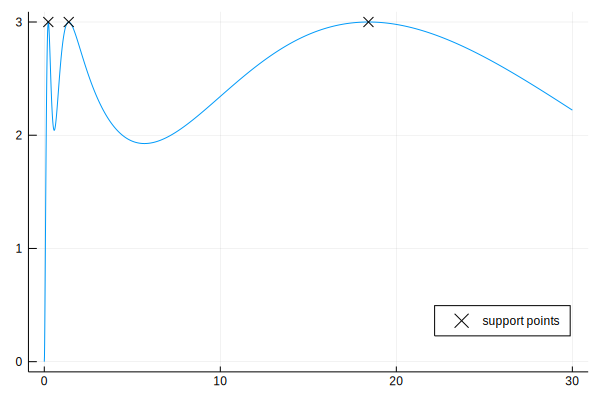

In [40]:
x = result[1]
w = result[2]
mat = zeros(3,3)
for i in 1:3
    c1 = x[i]*theta[3]*exp(-theta[1]*x[i])
    c2 = -x[i]*theta[3]*exp(-theta[2]*x[i]) 
    c3 = exp(-theta[2]*x[i])-exp(-theta[1]*x[i])
    f = [c1, c2, c3]
    mat = mat + w[i] .* f*f'
end
mati = inv(mat)

function equiv(x)
    c1 = x*theta[3]*exp(-theta[1]*x)
    c2 = -x*theta[3]*exp(-theta[2]*x) 
    c3 = exp(-theta[2]*x)-exp(-theta[1]*x)
    f = [c1, c2, c3]
    val = f' *mati*f
    return val
end

dp = 0:0.01:30
plot(dp, equiv.(dp), label="")
scatter!(result[1],equiv.(result[1]), markershape = :x, label="support points", legend = :bottomright)

## Stability (1000 iteration)

In [47]:
repx = zeros(10^3,3)
repw = zeros(10^3,3)
fopt = zeros(10^3)

for rep in 1:10^3
    result = diter()
    repx[rep,:] = result[1]
    repw[rep,:] = result[2]
    fopt[rep] = result[4]
end

In [49]:
perm = sortperm(fopt)
repx = repx[perm,:]
repw = repw[perm,:]
fopt = fopt[perm] .^ (1/legnth(theta))

plot(fopt)

1000-element Array{Float64,1}:
 10.542534865809758
 10.542534865872527
 10.542534865924832
 10.54253486595011 
 10.542534865951634
 10.542534865952462
 10.542534865953098
 10.542534865953423
 10.542534865953867
 10.542534865954602
 10.542534865964946
 10.5425348659691  
 10.54253486597173 
  ⋮                
 11.738774947508412
 11.738774947508992
 11.738774947509565
 11.738774947511073
 11.7387749475111  
 11.738774947512082
 11.738774947512445
 11.738774947513122
 11.738774947513546
 11.738774947513615
 11.738774947514127
 11.738774947515308

In [55]:
repw[100,:]

3-element Array{Float64,1}:
 0.333333399317406  
 0.33333356104612744
 0.33333303963646654

In [56]:
repw[1000,:]

3-element Array{Float64,1}:
 0.33333297226447584
 0.33333342090541784
 0.33333360683010627

In [51]:
fopt[1]/fopt[1000]

0.898094981200849

In [57]:
using StatsBase
countmap(round.(fopt,digits=3))

Dict{Float64,Int64} with 2 entries:
  10.543 => 365
  11.739 => 635

In [ ]:
repx[1000,:]

In [ ]:
repw[100,:]

In [ ]:
c1 = a[i]*theta[3]*exp(-theta[1]*a[i])
c2 = -a[i]*theta[3]*exp(-theta[2]*a[i]) 
c3 = exp(-theta[2]*a[i])-exp(-theta[1]*a[i])
f = [c1, c2, c3]
mat = mat + b[i] .* f*f'

In [ ]:
0.229,  1.389,  18.417

In [ ]:
#objective function h to minimize
function obj(x)
    theta = [0.05884, 4.298, 21.8]
    v = [x; 0.229; 1.389; 1/3; 1/3]
    n = Int((length(v)+1)/2)
    a = v[1:n]
    b = v[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    p = length(theta)
    mat = zeros(p,p)
    for i in 1:n
        c1 = a[i]*theta[3]*exp(-theta[1]*a[i])
        c2 = -a[i]*theta[3]*exp(-theta[2]*a[i]) 
        c3 = exp(-theta[2]*a[i])-exp(-theta[1]*a[i])
        f = [c1, c2, c3]
        mat = mat + b[i] .* f*f'
    end
    return log(det(mat)^(1/p))
end

In [ ]:
findmax(obj.(x),)

In [ ]:
x = 0:0.01:30
using Plots, LinearAlgebra
Plots.plot(x, obj.(x), legend=:none,
    xlab="x",ylab="D-optimality criterion")

In [ ]:
using Statistics
n = 100
save = zeros(100)
for i in 3:100
    temp = zeros(100)
    for j in 1:100
        global theta = [0.05884, 4.298, 21.8]
        global k = i
        global nptc = 100
        global niter = 100
        global design = [0,30]
        t1 = time()
        diter()
        t2 = time()
        temp[j] = t2-t1
    end
    save[i] = median(temp)
    print(i)
end

In [ ]:
]add JLD2, FileIO

In [ ]:
using JLD2, FileIO
@save "pso_save.jld2" save

In [89]:
function infmat(x)
    a = [0.230 , 1.447,  x]
    b = ones(3) ./ 3
    p = length(theta)
    mat = zeros(p,p)
    for i in 1:3
        c1 = a[i]*theta[3]*exp(-theta[1]*a[i])
        c2 = -a[i]*theta[3]*exp(-theta[2]*a[i]) 
        c3 = exp(-theta[2]*a[i])-exp(-theta[1]*a[i])
        f = [c1, c2, c3]
        mat = mat + b[i] .* f*f'
    end
    return det(mat)^(1/3)
end

infmat (generic function with 1 method)

In [86]:
dp[findmax(infmat.(dp))[2]]

1.45

In [80]:
infmat(0)

11.733572387700823

In [78]:
infmat(0)

11.738662041602186

In [81]:
11.733572387700823/11.738662041602186

0.9995664195899562

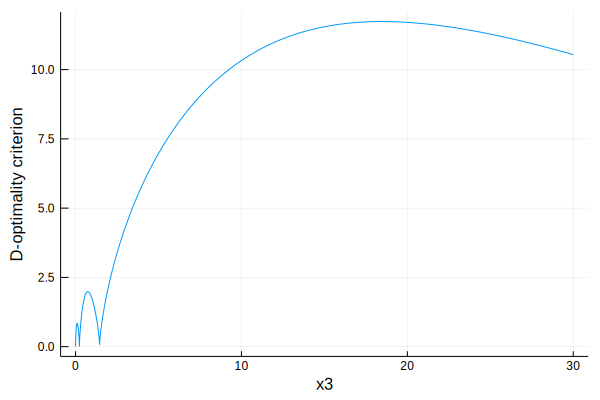

In [90]:
plot(dp, infmat.(dp), label ="", xlab="x3", ylab = "D-optimality criterion")

In [96]:
theta = [0.05884, 4.298, 21.8]
k = 3
nptc = 100
niter = 100
design = [0,30]

result = diter()

6-element Array{Any,1}:
     [18.4167, 0.228771, 1.38859]  
     [0.333335, 0.333328, 0.333337]
    0.345819553                    
 1617.5895382610338                
    8.692610276739288e-5           
     RecipesBase.plot              

In [97]:
theta = [0.05884, 4.298, 21.8]
k = 4
nptc = 100
niter = 100
design = [0,30]

result = diter()

6-element Array{Any,1}:
     [0.228773, 1.38859, 18.4167, 30.0] 
     [0.333334, 0.333338, 0.333328, 0.0]
    0.387917671                         
 1617.589538166719                      
    2.955457034659048e-5                
     RecipesBase.plot                   

In [99]:
theta = [0.05884, 4.298, 21.8]
k = 5
nptc = 100
niter = 100
design = [0,30]

result = diter()

6-element Array{Any,1}:
     [0.229554, 1.44738, 30.0, 0.0, 30.0]           
     [0.333333, 0.333334, 0.00323365, 0.0, 0.330099]
    0.410895954                                     
 1171.7504741537766                                 
    3.776131052291021e-7                            
     RecipesBase.plot                               

In [100]:
fopt = zeros(100)
ft = zeros(100)

for i = 1:100
    global k = 3*i
    res = diter()
    fopt[i] = res[4]^(1/3)
    ft[i] = res[3]
end

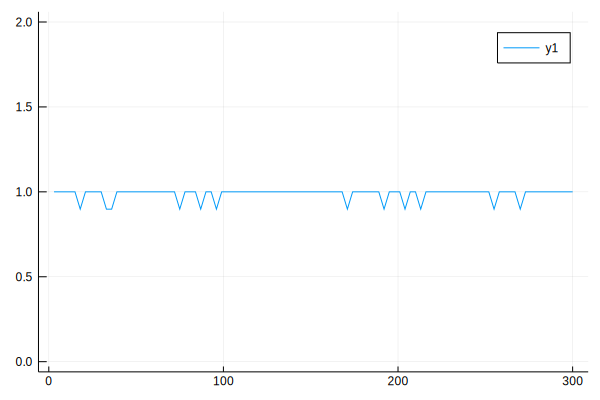

In [101]:
plot(3*(1:100), fopt ./ fopt[1],ylim = [0, 2] )

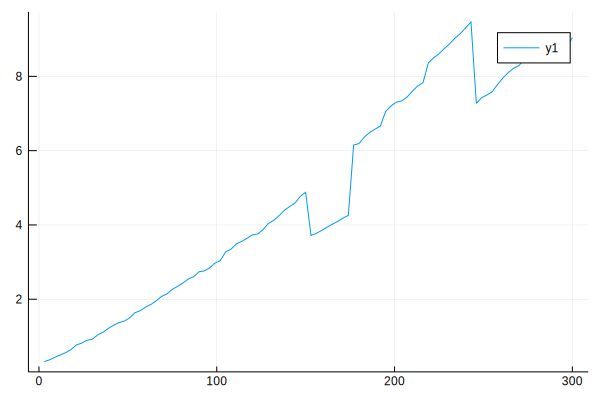

In [102]:
plot(3*(1:100), ft)